Please answer completely all four required questions (250 Points).

### Question 1: Load (50 Points)

- Programmatically download and load into your favorite analytical tool the transactions data. This data, which is in line-delimited JSON format, can be found as transactions.txt (above attached)

- Please describe the structure of the data. Number of records and fields in each record?

- Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
df = pd.read_json('transactions.txt', lines=True)

In [4]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


In [5]:
print("Dataset Overview:")
print(f"Number of records: {len(df):,}")
print(f"Number of fields: {len(df.columns)}")
print("\nData Types:")
print(df.dtypes)

Dataset Overview:
Number of records: 786,363
Number of fields: 29

Data Types:
accountNumber                 int64
customerId                    int64
creditLimit                   int64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                       int64
enteredCVV                    int64
cardLast4Digits               int64
transactionType              object
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises        

In [6]:
num_records = len(df)
print(f"Number of records: {num_records:,}")

Number of records: 786,363


In [7]:
num_fields = len(df.columns)
print(f"Number of fields in each record: {num_fields}")
print(f"Fields: {', '.join(df.columns)}")

Number of fields in each record: 29
Fields: accountNumber, customerId, creditLimit, availableMoney, transactionDateTime, transactionAmount, merchantName, acqCountry, merchantCountryCode, posEntryMode, posConditionCode, merchantCategoryCode, currentExpDate, accountOpenDate, dateOfLastAddressChange, cardCVV, enteredCVV, cardLast4Digits, transactionType, echoBuffer, currentBalance, merchantCity, merchantState, merchantZip, cardPresent, posOnPremises, recurringAuthInd, expirationDateKeyInMatch, isFraud


In [8]:
# Statistics
print("\nSummary statistics:")
for column in df.columns:
    print(f"\nField: {column}")
    # Null values
    null_count = df[column].isnull().sum()
    print(f"  Null count: {null_count}")
    
    # Unique values
    unique_count = df[column].nunique()
    print(f"  Unique values: {unique_count}")
    
    # Min and max
    if pd.api.types.is_numeric_dtype(df[column]):
        print(f"  Min: {df[column].min()}")
        print(f"  Max: {df[column].max()}")
        print(f"  Mean: {df[column].mean()}")
    
    # If its a string field then min and max length
    elif pd.api.types.is_string_dtype(df[column]):
        if null_count < len(df): 
            # Length
            lengths = df[column].dropna().astype(str).apply(len)
            if not lengths.empty:
                print(f"  Min length: {lengths.min()}")
                print(f"  Max length: {lengths.max()}")
    

    if unique_count < 20 and unique_count > 0:
        sample_values = df[column].dropna().unique()[:5]  # Get first 5 unique values
        print(f"  Sample values: {', '.join(map(str, sample_values))}")



Summary statistics:

Field: accountNumber
  Null count: 0
  Unique values: 5000
  Min: 100088067
  Max: 999389635
  Mean: 537232599.4617028

Field: customerId
  Null count: 0
  Unique values: 5000
  Min: 100088067
  Max: 999389635
  Mean: 537232599.4617028

Field: creditLimit
  Null count: 0
  Unique values: 10
  Min: 250
  Max: 50000
  Mean: 10759.464458526152
  Sample values: 5000, 2500, 50000, 15000, 10000

Field: availableMoney
  Null count: 0
  Unique values: 521915
  Min: -1005.63
  Max: 50000.0
  Mean: 6250.725369288736

Field: transactionDateTime
  Null count: 0
  Unique values: 776637
  Min length: 19
  Max length: 19

Field: transactionAmount
  Null count: 0
  Unique values: 66038
  Min: 0.0
  Max: 2011.54
  Mean: 136.98579095150708

Field: merchantName
  Null count: 0
  Unique values: 2490
  Min length: 4
  Max length: 30

Field: acqCountry
  Null count: 0
  Unique values: 5
  Min length: 0
  Max length: 3
  Sample values: US, , CAN, MEX, PR

Field: merchantCountryCode
  Nu

### Question 2: Plot (25 Points)

- Plot a histogram of the processed amounts of each transaction, the transactionAmount column.

- Report any structure you find and any hypotheses you have about that structure.

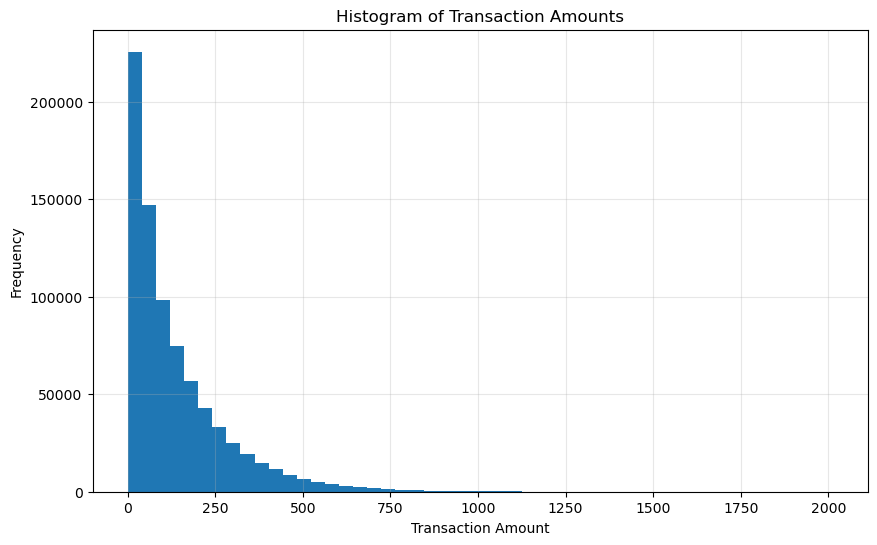

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(df['transactionAmount'], bins=50)
plt.title('Histogram of Transaction Amounts')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

_The histogram shows a strong positive skew with a high concentration of transactions under $250 and a long tail that stretches to around $2,000. The frequency of transactions declines exponentially as the amount increases, with the highest frequency at the lowest end, suggesting that very small transactions are the most common. This is likely due to the strenght of everyday purchases, while larger transactions are rare, especially above $750._

_There also appear to be spikes at round numbers like $20, $50, and $100 that could be reflecting typical consumer behavior or preset pricing tiers. The decrease in frequency beyond $250 reflects more cautious spending patterns as purchase amounts increase. If the data is from a specific business, it might suggest a model centered around high-volume, low-value transactions._

_The few extreme values in the long tail may require further investigation for potential anomalies or fraud, especially if they deviate from a customer’s normal spending pattern. A log transformation of the transaction amounts could help normalize the distribution for modeling purposes and reduce the influence of those large outliers. One hypothesis is that fraud may be more likely at the extremes either very small amounts used to test stolen cards or large amounts used to exploit credit limits._

### Question 3: Data Wrangling - Duplicate Transactions (75 Points)

You will notice a number of what look like duplicated transactions in the data set. One type of duplicated transaction is a reversed transaction, where a purchase is followed by a reversal. Another example is a multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span.

- Can you programmatically identify reversed and multi-swipe transactions?

- What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts).

- Did you find anything interesting about either kind of transaction?


In [10]:
# Reversed transactions
def identify_reversed_transactions(transactions_df):
    df_copy = transactions_df.copy()
    
    if 'accountNumber' not in df_copy.columns:
        raise ValueError("accountNumber not found in the dataset")
    
    if 'transactionAmount' not in df_copy.columns:
        raise ValueError("transactionAmount field not found in the dataset")
    
    if 'transactionDateTime' not in df_copy.columns:
        raise ValueError("transactionDateTime field not found in the dataset")
    
    # Sorting by account and transaction datetime
    df_copy = df_copy.sort_values(['accountNumber', 'transactionDateTime'])
    
    # Unique ID per transaction
    df_copy['transaction_id'] = range(len(df_copy))
    
    #Sshifted dataframe to compare consecutive transactions
    df_shifted = df_copy.shift(-1)
    
    # 3 days is common in banking for time reversals
    time_threshold = pd.Timedelta(days=3)
    
    # Potential reversals: same account, opposite amount and close in time.
    reversals = (
        (df_copy['accountNumber'] == df_shifted['accountNumber']) &
        (df_copy['transactionAmount'] == -df_shifted['transactionAmount']) &
        ((df_shifted['transactionDateTime'] - df_copy['transactionDateTime']) <= time_threshold)
    )
    
    # Original transactions and their reversals
    original_txns = df_copy[reversals].copy()
    reversal_txns = df_copy.shift(-1)[reversals].copy()
    
    # Reversal pairs
    reversal_pairs = pd.DataFrame({
        'original_id': original_txns['transaction_id'].values,
        'reversal_id': reversal_txns['transaction_id'].values,
        'accountNumber': original_txns['accountNumber'].values,
        'original_amount': original_txns['transactionAmount'].values,
        'reversal_amount': reversal_txns['transactionAmount'].values,
        'original_datetime': original_txns['transactionDateTime'].values,
        'reversal_datetime': reversal_txns['transactionDateTime'].values,
        'time_difference': reversal_txns['transactionDateTime'].values - original_txns['transactionDateTime'].values
    })
    
    # Reversal flags to the original dataframe
    df_copy['is_reversal_pair'] = False
    df_copy.loc[df_copy['transaction_id'].isin(original_txns['transaction_id']), 'is_reversal_pair'] = True
    df_copy.loc[df_copy['transaction_id'].isin(reversal_txns['transaction_id']), 'is_reversal_pair'] = True
    
    df_copy['is_original_txn'] = df_copy['transaction_id'].isin(original_txns['transaction_id'])
    df_copy['is_reversal_txn'] = df_copy['transaction_id'].isin(reversal_txns['transaction_id'])
    
    return df_copy, reversal_pairs

In [11]:
# Multi-swipe transactions
def identify_multi_swipes(transactions_df, time_threshold_minutes=10, amount_threshold=0.01):
    """
    Mmulti-swipe transactions based on the same account, same merchant, similar amount and close timestamp.
    
    Parameters:
    - transactions_df: DataFrame containing transaction data
    - time_threshold_minutes: Maximum time difference between transactions to be considered multi-swipes
    - amount_threshold: Maximum proportional difference in amount to be considered similar
    """
    df_copy = transactions_df.copy()
    
    if 'accountNumber' not in df_copy.columns:
        raise ValueError("accountNumber not found in the dataset")
    
    if 'merchantName' not in df_copy.columns:
        raise ValueError("merchantName not found in the dataset")
    
    if 'transactionAmount' not in df_copy.columns:
        raise ValueError("transactionAmount field not found in the dataset")
    
    # Datetime
    if 'transactionDateTime' in df_copy.columns:
        if df_copy['transactionDateTime'].dtype != 'datetime64[ns]':
            df_copy['transactionDateTime'] = pd.to_datetime(df_copy['transactionDateTime'])
    else:
        raise ValueError("transactionDateTime field not found in the dataset")
    
    # Unique ID per transaction
    df_copy['transaction_id'] = range(len(df_copy))
    
    df_copy['is_multi_swipe'] = False
    df_copy['multi_swipe_group'] = None
    
    # Time threshold
    time_delta = pd.Timedelta(minutes=time_threshold_minutes)
    
    multi_swipe_group_counter = 0
    
    # Grouping by account and merchant
    grouped = df_copy.groupby(['accountNumber', 'merchantName'])
    
    # Process each group
    for (account, merchant), group_df in grouped:
        # Skiping if group has only one transaction
        if len(group_df) <= 1:
            continue
        
        # Sorting by datetime
        sorted_df = group_df.sort_values('transactionDateTime')
        
        current_group = []
        base_amount = None
        base_time = None
        
        # Processing transactions in chronological order
        for idx, row in sorted_df.iterrows():
            if base_amount is None:
                base_amount = row['transactionAmount']
                base_time = row['transactionDateTime']
                current_group = [idx]
            else:
                # Checking if this transaction is similar to the base transaction
                amount_difference = abs(row['transactionAmount'] - base_amount)
                is_similar_amount = amount_difference <= amount_threshold * abs(base_amount)
                is_close_time = (row['transactionDateTime'] - base_time) <= time_delta
                
                if is_similar_amount and is_close_time:
                    current_group.append(idx)
                else:
                    # Do we have a multi-swipe group
                    if len(current_group) > 1:
                        # Mark transactions as multi-swipes
                        df_copy.loc[current_group, 'is_multi_swipe'] = True
                        df_copy.loc[current_group, 'multi_swipe_group'] = multi_swipe_group_counter
                        multi_swipe_group_counter += 1
                    
                    base_amount = row['transactionAmount']
                    base_time = row['transactionDateTime']
                    current_group = [idx]
        
        # Checking the last group
        if len(current_group) > 1:
            df_copy.loc[current_group, 'is_multi_swipe'] = True
            df_copy.loc[current_group, 'multi_swipe_group'] = multi_swipe_group_counter
            multi_swipe_group_counter += 1
    
    return df_copy

In [12]:
# Reversal transactions
def analyze_reversals(df_with_reversals, reversal_pairs):
    """
    Parameters:
    - df_with_reversals: DataFrame with reversal flags
    - reversal_pairs: DataFrame with reversal pairs
    """
    # Counting reversal pairs
    num_reversed_txns = len(reversal_pairs)
    
    # Total amount involved in reversals
    total_reversed_amount = reversal_pairs['original_amount'].abs().sum()
    
    # Average time between original and reversal
    avg_time_to_reversal = reversal_pairs['time_difference'].mean()
    
    # Checking if reversals are more likely to be fraudulent
    if 'isFraud' in df_with_reversals.columns:
        fraud_rate_reversal = df_with_reversals[df_with_reversals['is_reversal_txn']]['isFraud'].mean() * 100
        fraud_rate_normal = df_with_reversals[~df_with_reversals['is_reversal_txn']]['isFraud'].mean() * 100
    else:
        fraud_rate_reversal = None
        fraud_rate_normal = None
    
    # Most common merchants with reversals
    if 'merchantName' in df_with_reversals.columns:
        top_reversal_merchants = df_with_reversals[df_with_reversals['is_reversal_txn']].groupby('merchantName').size().sort_values(ascending=False).head(10)
    else:
        top_reversal_merchants = None
    
    return {
        'num_reversed_txns': num_reversed_txns,
        'total_reversed_amount': total_reversed_amount,
        'avg_time_to_reversal': avg_time_to_reversal,
        'fraud_rate_reversal': fraud_rate_reversal,
        'fraud_rate_normal': fraud_rate_normal,
        'top_reversal_merchants': top_reversal_merchants
    }

In [13]:
# Function to analyze multi-swipe transactions
def analyze_multi_swipes(df_with_multi_swipes):
    """
    Parameters:
    - df_with_multi_swipes: DataFrame with multi-swipe flags and groups
    """
    # Counting multi-swipe groups
    multi_swipe_df = df_with_multi_swipes[df_with_multi_swipes['is_multi_swipe']]
    
    if len(multi_swipe_df) == 0:
        return {
            'total_groups': 0,
            'total_extra_txns': 0,
            'total_amount': 0,
            'fraud_rate_multi': None,
            'fraud_rate_normal': None
        }
    
    # Unique groups
    groups = multi_swipe_df['multi_swipe_group'].unique()
    
    # Statistics
    total_groups = len(groups)
    group_sizes = multi_swipe_df.groupby('multi_swipe_group').size()
    total_extra_txns = sum(group_sizes) - total_groups  # Exclude first transaction in each group
    
    # Total amount of extra transactions
    total_amount = 0
    for group_id in groups:
        group_data = multi_swipe_df[multi_swipe_df['multi_swipe_group'] == group_id].sort_values('transactionDateTime')
        # Suming the amounts of all but the first transaction
        if len(group_data) > 1:
            extra_amount = group_data['transactionAmount'].iloc[1:].sum()
            total_amount += extra_amount
    
    # Checking if multi-swipes are more likely to be fraudulent
    if 'isFraud' in df_with_multi_swipes.columns:
        fraud_rate_multi = df_with_multi_swipes[df_with_multi_swipes['is_multi_swipe']]['isFraud'].mean() * 100
        fraud_rate_normal = df_with_multi_swipes[~df_with_multi_swipes['is_multi_swipe']]['isFraud'].mean() * 100
    else:
        fraud_rate_multi = None
        fraud_rate_normal = None
    
    return {
        'total_groups': total_groups,
        'total_extra_txns': total_extra_txns,
        'total_amount': total_amount,
        'group_sizes': group_sizes,
        'fraud_rate_multi': fraud_rate_multi,
        'fraud_rate_normal': fraud_rate_normal
    }

In [14]:
def load_data(file_path='transactions.txt'):
    try:
        df = pd.read_json(file_path, lines=True)
        # Transaction datetime to datetime format
        df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [15]:
def main():
    # Load the data
    df = load_data()
    if df is None:
        return
    
    print("Data loaded successfully.")
    print(f"Number of records: {len(df)}")
    
    # Identifying the reversed transactions
    df_with_reversals, reversal_pairs = identify_reversed_transactions(df)
    
    # Analyzing reversed transactions
    reversal_stats = analyze_reversals(df_with_reversals, reversal_pairs)
    
    print("\n--- Reversed Transactions Analysis ---")
    print(f"Number of reversed transaction pairs: {reversal_stats['num_reversed_txns']}")
    print(f"Total amount in original transactions that were reversed: ${reversal_stats['total_reversed_amount']:,.2f}")
    print(f"Average time between original transaction and reversal: {reversal_stats['avg_time_to_reversal']}")
    
    if reversal_stats['fraud_rate_reversal'] is not None:
        print(f"Fraud rate in reversal transactions: {reversal_stats['fraud_rate_reversal']:.4f}%")
        print(f"Fraud rate in non-reversal transactions: {reversal_stats['fraud_rate_normal']:.4f}%")
    
    # Time differences for reversals
    plt.figure(figsize=(12, 6))
    plt.hist(reversal_pairs['time_difference'].dt.total_seconds() / 3600, bins=50)
    plt.title('Time Between Original Transaction and Reversal (Hours)')
    plt.xlabel('Hours')
    plt.ylabel('Frequency')
    plt.savefig('reversal_time_histogram.png')
    plt.close()
    
    # Multi-swipe transactions
    df_with_multi_swipes = identify_multi_swipes(df)
    
    # Analyzing multi-swipe transactions
    multi_swipe_stats = analyze_multi_swipes(df_with_multi_swipes)
    
    print("\n--- Multi-Swipe Transactions Analysis ---")
    print(f"Number of multi-swipe groups: {multi_swipe_stats['total_groups']}")
    print(f"Number of extra transactions due to multi-swipes: {multi_swipe_stats['total_extra_txns']}")
    print(f"Total amount in multi-swipe transactions (excluding first): ${multi_swipe_stats['total_amount']:,.2f}")
    
    if multi_swipe_stats['fraud_rate_multi'] is not None:
        print(f"Fraud rate in multi-swipe transactions: {multi_swipe_stats['fraud_rate_multi']:.4f}%")
        print(f"Fraud rate in non-multi-swipe transactions: {multi_swipe_stats['fraud_rate_normal']:.4f}%")
    
    # Distribution of multi-swipe group sizes
    if multi_swipe_stats['total_groups'] > 0:
        plt.figure(figsize=(10, 6))
        group_sizes = multi_swipe_stats['group_sizes']
        plt.hist(group_sizes, bins=range(2, max(group_sizes) + 2))
        plt.title('Distribution of Multi-Swipe Group Sizes')
        plt.xlabel('Number of Transactions in Group')
        plt.ylabel('Frequency')
        plt.xticks(range(2, max(group_sizes) + 1))
        plt.savefig('multi_swipe_group_sizes.png')
        plt.close()
    
    print("\n--- Additional Insights ---")
    if reversal_stats['top_reversal_merchants'] is not None:
        print("Top merchants with reversed transactions:")
        print(reversal_stats['top_reversal_merchants'])
    
    # Checking for a relationships between reversed and multi-swipe transactions
    if multi_swipe_stats['total_groups'] > 0:
        df_combined = df_with_reversals.copy()
        df_combined['is_multi_swipe'] = df_with_multi_swipes['is_multi_swipe']
        
        # Checking overlap
        both_flags = df_combined[(df_combined['is_reversal_pair']) & (df_combined['is_multi_swipe'])]
        overlap_count = len(both_flags)
        
        print(f"\nTransactions that are both reversals and multi-swipes: {overlap_count}")
        
        if overlap_count > 0:
            overlap_fraud_rate = both_flags['isFraud'].mean() * 100
            print(f"Fraud rate in overlap transactions: {overlap_fraud_rate:.4f}%")
    
    # Looking for amount patterns
    print("\nAnalyzing transaction amount patterns...")
    amount_analysis = {
        'round_amounts': len(df[df['transactionAmount'].apply(lambda x: x == round(x, 0))]),
        'ending_99': len(df[df['transactionAmount'].apply(lambda x: abs(x - round(x) + 0.99) < 0.01)]),
        'under_1': len(df[df['transactionAmount'] < 1.0]),
        'over_1000': len(df[df['transactionAmount'] > 1000.0])
    }
    
    total_txns = len(df)
    print(f"Transactions with round dollar amounts: {amount_analysis['round_amounts']} ({amount_analysis['round_amounts']/total_txns*100:.2f}%)")
    print(f"Transactions ending in .99: {amount_analysis['ending_99']} ({amount_analysis['ending_99']/total_txns*100:.2f}%)")
    print(f"Transactions under $1.00: {amount_analysis['under_1']} ({amount_analysis['under_1']/total_txns*100:.2f}%)")
    print(f"Transactions over $1,000.00: {amount_analysis['over_1000']} ({amount_analysis['over_1000']/total_txns*100:.2f}%)")
    
    # Summary
    print("\n My findings")
    print(f"1. Reversed Transactions: {reversal_stats['num_reversed_txns']} pairs, ${reversal_stats['total_reversed_amount']:,.2f} total amount")
    print(f"2. Multi-Swipe Transactions: {multi_swipe_stats['total_groups']} groups, {multi_swipe_stats['total_extra_txns']} extra transactions, ${multi_swipe_stats['total_amount']:,.2f} total amount")
    
    if reversal_stats['fraud_rate_reversal'] is not None and reversal_stats['fraud_rate_normal'] is not None:
        if reversal_stats['fraud_rate_reversal'] > reversal_stats['fraud_rate_normal']:
            print(f"3. Reversal transactions have {reversal_stats['fraud_rate_reversal']/reversal_stats['fraud_rate_normal']:.2f}x higher fraud rate than normal transactions")
        else:
            print(f"3. Reversal transactions have lower fraud rate than normal transactions")

    if multi_swipe_stats['fraud_rate_multi'] is not None and multi_swipe_stats['fraud_rate_normal'] is not None:
        if multi_swipe_stats['fraud_rate_multi'] > multi_swipe_stats['fraud_rate_normal']:
            print(f"4. Multi-swipe transactions have {multi_swipe_stats['fraud_rate_multi']/multi_swipe_stats['fraud_rate_normal']:.2f}x higher fraud rate than normal transactions")
        else:
            print(f"4. Multi-swipe transactions have lower fraud rate than normal transactions")
    
    return df_with_reversals, reversal_pairs, df_with_multi_swipes, reversal_stats, multi_swipe_stats

if __name__ == "__main__":
    main()

Data loaded successfully.
Number of records: 786363

--- Reversed Transactions Analysis ---
Number of reversed transaction pairs: 910
Total amount in original transactions that were reversed: $0.00
Average time between original transaction and reversal: 0 days 08:05:05.502197802
Fraud rate in reversal transactions: 0.5495%
Fraud rate in non-reversal transactions: 1.5802%

--- Multi-Swipe Transactions Analysis ---
Number of multi-swipe groups: 12633
Number of extra transactions due to multi-swipes: 13411
Total amount in multi-swipe transactions (excluding first): $1,935,384.54
Fraud rate in multi-swipe transactions: 1.7547%
Fraud rate in non-multi-swipe transactions: 1.5730%

--- Additional Insights ---
Top merchants with reversed transactions:
merchantName
alibaba.com      33
Uber             32
Lyft             28
staples.com      25
target.com       23
amazon.com       22
cheapfast.com    22
walmart.com      22
gap.com          20
oldnavy.com      19
dtype: int64

Transactions that a

_After analyzing the dataset, I identified 910 reversed transaction pairs, but the total dollar amount reversed was $0.00, this could be likely due to these being placeholders or test transactions. I saw that the reversed transactions had a lower fraud rate of 0.55% compared to the rest of the dataset of 1.58%, which suggests that reversals may often occur in legitimate customer scenarios. I found 12,633 multi-swipe groups, resulting in 13,411 extra transactions and over $1.93 million in duplicated charges. Multi-swipe transactions showed a slightly higher fraud rate of 1.75%, indicating they may occasionally be exploited maliciously or trigger fraud detection flags. Also, 774 transactions were flagged as both reversals and multi-swipes, but this overlapping group had a relatively low fraud rate of 0.78%. These patterns show important insights into how errors like double charges or reversals can intersect with potential fraud risks, and they highlight the importance of distinguishing between human error and fraudulent behavior in transaction monitoring._

### Question 4: Model (100 Points)

Fraud is a problem for any bank. Fraud can take many forms, whether it is someone stealing a single credit card, to large batches of stolen credit card numbers being used on the web, or even a mass compromise of credit card numbers stolen from a merchant via tools like credit card skimming devices.

- Each of the transactions in the dataset has a field called isFraud. Please build a machine learning model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).

- Provide an estimate of performance using an appropriate sample, and show your work.

- Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time).

In [16]:
# Fraud detection EDA
print("\n--- Fraud Detection EDA ---")
fraud_count = df['isFraud'].sum()
fraud_percentage = fraud_count / len(df) * 100
print(f"Fraud transactions: {fraud_count} ({fraud_percentage:.4f}%)")


--- Fraud Detection EDA ---
Fraud transactions: 12417 (1.5790%)


In [17]:
# Feature Engineering
def engineer_features(df):
    """Create new features for fraud detection modeling"""
    features = df.copy()
    
    # Time-based
    features['hour'] = features['transactionDateTime'].dt.hour
    features['day_of_week'] = features['transactionDateTime'].dt.dayofweek
    features['is_weekend'] = features['day_of_week'].isin([5, 6]).astype(int)
    features['month'] = features['transactionDateTime'].dt.month
    
    # Account age
    features['accountOpenDate'] = pd.to_datetime(features['accountOpenDate'])
    features['account_age_days'] = (features['transactionDateTime'] - features['accountOpenDate']).dt.days
    
    # Last address change
    features['dateOfLastAddressChange'] = pd.to_datetime(features['dateOfLastAddressChange'])
    features['days_since_address_change'] = (features['transactionDateTime'] - features['dateOfLastAddressChange']).dt.days
    
    # Transaction amount
    features['amount_abs'] = features['transactionAmount'].abs()
    features['amount_is_round'] = (features['amount_abs'] % 1 == 0).astype(int)
    features['amount_cents'] = (features['amount_abs'] * 100) % 100
    features['amount_log'] = np.log1p(features['amount_abs'])
    
    # Credit use
    features['credit_utilization'] = 1 - (features['availableMoney'] / features['creditLimit'])
    features['amount_to_limit_ratio'] = features['amount_abs'] / features['creditLimit']
    
    # Card verification 
    features['cvv_match'] = (features['cardCVV'] == features['enteredCVV']).astype(int)
    
    # Cross-border transaction
    features['is_cross_border'] = (features['merchantCountryCode'] != features['acqCountry']).astype(int)
    
    # Transaction frequency per account
    account_txn_counts = features.groupby('accountNumber').size()
    features['account_txn_count'] = features['accountNumber'].map(account_txn_counts)
    
    # Average transaction amount per account
    account_avg_amounts = features.groupby('accountNumber')['transactionAmount'].mean()
    features['account_avg_amount'] = features['accountNumber'].map(account_avg_amounts)
    
    # Transaction amount relative to average for this account
    features['amount_to_avg_ratio'] = features['transactionAmount'] / features['account_avg_amount']
    
    # Merchant features
    merchant_txn_counts = features.groupby('merchantName').size()
    features['merchant_txn_count'] = features['merchantName'].map(merchant_txn_counts)
    
    # Fraud rate per merchant category code
    mcc_fraud_rates = features.groupby('merchantCategoryCode')['isFraud'].mean()
    features['mcc_fraud_rate'] = features['merchantCategoryCode'].map(mcc_fraud_rates)
    
    # Handle infinite values that might occur in ratios
    for col in ['amount_to_avg_ratio', 'amount_to_limit_ratio']:
        features[col] = features[col].replace([np.inf, -np.inf], np.nan)
    
    return features


In [18]:
# Ensure 'transactionDateTime', 'accountOpenDate', and 'dateOfLastAddressChange' are in datetime format
df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], errors='coerce')
df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'], errors='coerce')
df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'], errors='coerce')

# Applying the feature engineering
df_features = engineer_features(df)

# Filling null values
null_columns = df_features.columns[df_features.isnull().any()].tolist()
print(f"\nColumns with null values: {null_columns}")

for col in null_columns:
    if df_features[col].dtype == 'object':
        df_features[col] = df_features[col].fillna('unknown')
    else:
        df_features[col] = df_features[col].fillna(df_features[col].median())

# Relevant features for modeling
numeric_features = [
    'transactionAmount', 'amount_abs', 'amount_log', 'credit_utilization', 
    'amount_to_limit_ratio', 'account_age_days', 'days_since_address_change',
    'hour', 'account_txn_count', 'account_avg_amount', 'amount_to_avg_ratio',
    'merchant_txn_count', 'mcc_fraud_rate'
]

categorical_features = [
    'merchantCategoryCode', 'posEntryMode', 'posConditionCode'
]

boolean_features = [
    'cvv_match', 'cardPresent', 'is_weekend', 'amount_is_round', 
    'is_cross_border', 'expirationDateKeyInMatch'
]

# Features to numeric
for feature in boolean_features:
    df_features[feature] = df_features[feature].astype(int)
numeric_features.extend(boolean_features)

# Checking for missing features in the dataframe
numeric_features = [f for f in numeric_features if f in df_features.columns]
categorical_features = [f for f in categorical_features if f in df_features.columns]

print("\nSelected Features:")
print(f"Numeric: {numeric_features}")
print(f"Categorical: {categorical_features}")



Columns with null values: ['amount_to_avg_ratio']

Selected Features:
Numeric: ['transactionAmount', 'amount_abs', 'amount_log', 'credit_utilization', 'amount_to_limit_ratio', 'account_age_days', 'days_since_address_change', 'hour', 'account_txn_count', 'account_avg_amount', 'amount_to_avg_ratio', 'merchant_txn_count', 'mcc_fraud_rate', 'cvv_match', 'cardPresent', 'is_weekend', 'amount_is_round', 'is_cross_border', 'expirationDateKeyInMatch']
Categorical: ['merchantCategoryCode', 'posEntryMode', 'posConditionCode']


In [19]:
X = df_features[numeric_features + categorical_features]
y = df_features['isFraud']

# Stratisfied train-test split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Fraud transactions in training set: {y_train.sum()} ({y_train.mean() * 100:.4f}%)")
print(f"Fraud transactions in test set: {y_test.sum()} ({y_test.mean() * 100:.4f}%)")


Training set shape: (629090, 22)
Test set shape: (157273, 22)
Fraud transactions in training set: 9934 (1.5791%)
Fraud transactions in test set: 2483 (1.5788%)


In [20]:
import xgboost as xgb

# Preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# XGBoost is good for imbalanced classification tasks
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss',
    scale_pos_weight=len(y_train) / y_train.sum(), 
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

model.fit(X_train, y_train)


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:19:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['transactionAmount',
                                                   'amount_abs', 'amount_log',
                                                   'credit_utilization',
                                                   'amount_to_limit_ratio',
                                                   'account_age_days',
                                                   'days_since_address_change',
                                                   'hour', 'account_txn_count',
                                                   'account_avg_amount',
                                                   'amount_to_avg_ratio',
                                                   'merchant_txn_count',
                                                   'mc...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [21]:
# Predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Performance metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.74      0.85    154790
        True       0.04      0.73      0.08      2483

    accuracy                           0.74    157273
   macro avg       0.52      0.74      0.47    157273
weighted avg       0.98      0.74      0.84    157273



ROC AUC: 0.8198
Precision-Recall AUC: 0.0991


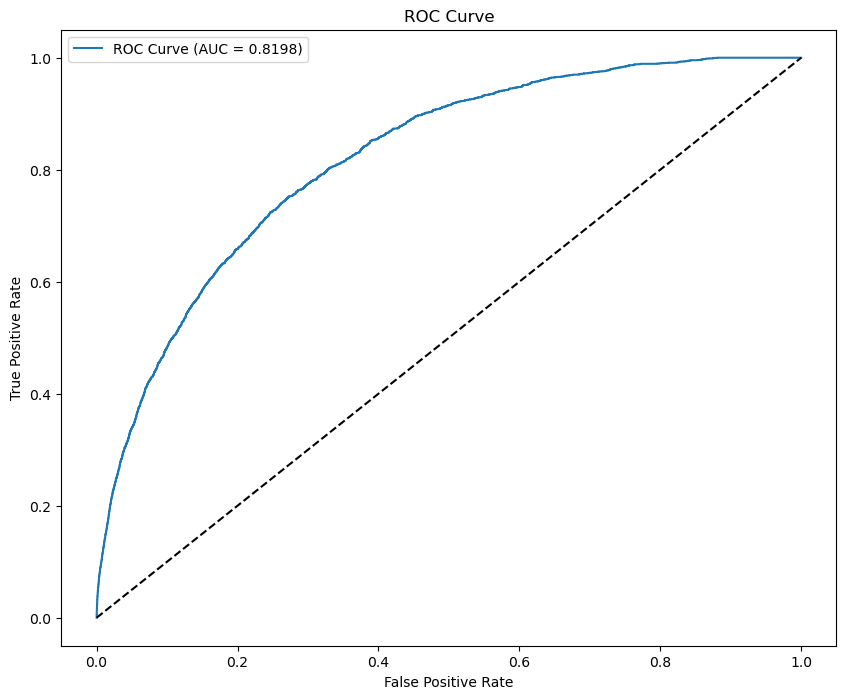

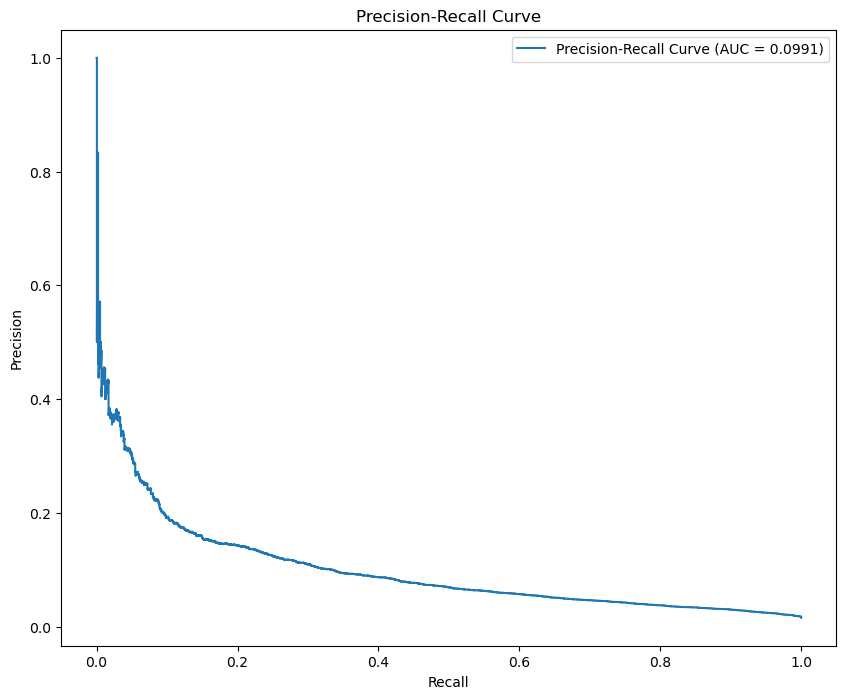

In [22]:
# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC: {roc_auc:.4f}")

# Precision-Recall AUC is more relevant for imbalanced classification
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
print(f"Precision-Recall AUC: {pr_auc:.4f}")

# ROC curve
plt.figure(figsize=(10, 8))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Precision-Recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label=f'Precision-Recall Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


Optimal Threshold (based on F1): 0.8101

Model Performance at Optimal Threshold:
              precision    recall  f1-score   support

       False       0.99      0.98      0.98    154790
        True       0.14      0.23      0.17      2483

    accuracy                           0.96    157273
   macro avg       0.56      0.60      0.58    157273
weighted avg       0.97      0.96      0.97    157273



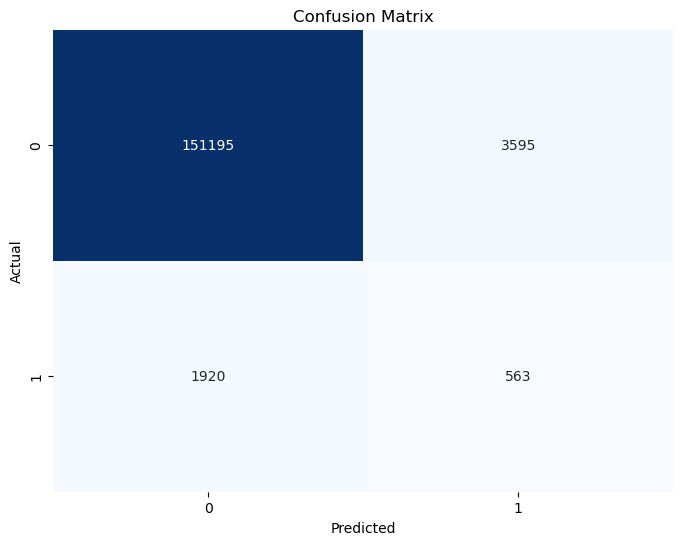

In [23]:
# Optimal threshold on F1 score
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1])
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal Threshold (based on F1): {optimal_threshold:.4f}")

# Recalculating metrics
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
print("\nModel Performance at Optimal Threshold:")
print(classification_report(y_test, y_pred_optimal))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_optimal)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

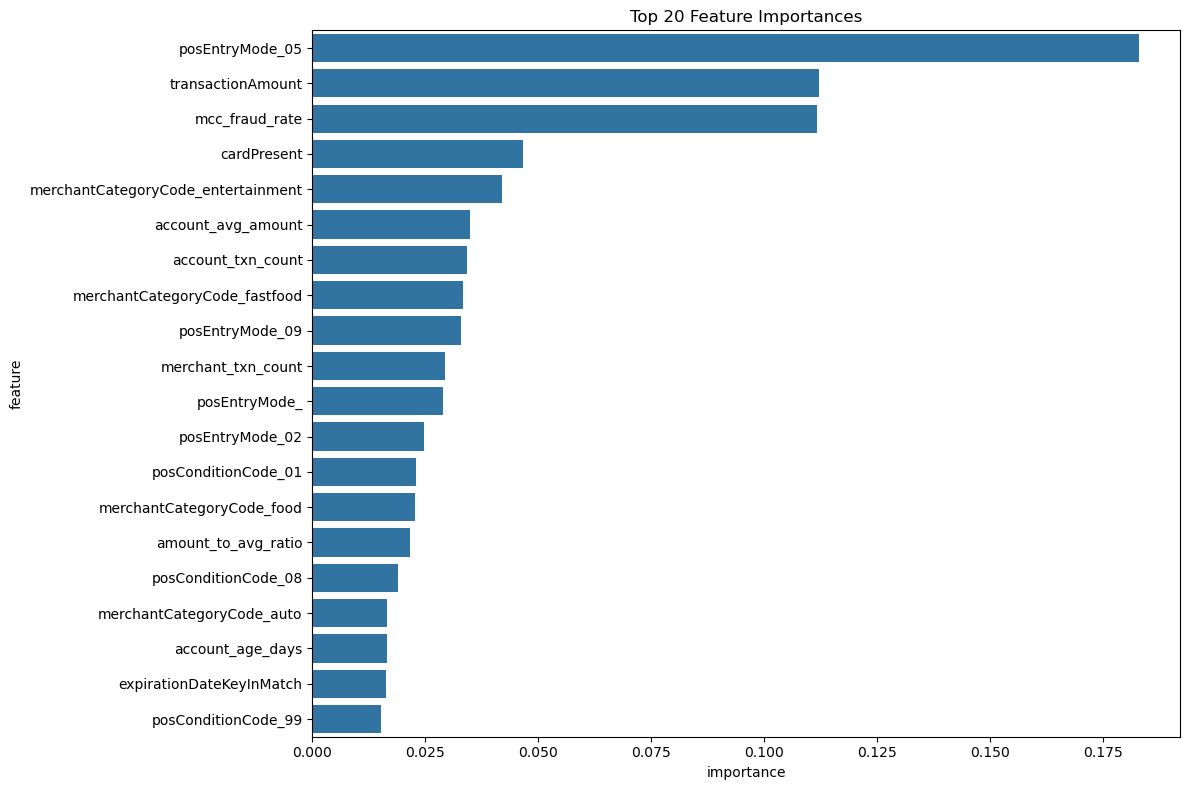


Top 10 Important Features:
                               feature  importance
40                     posEntryMode_05    0.182827
0                    transactionAmount    0.112089
12                      mcc_fraud_rate    0.111687
14                         cardPresent    0.046556
22  merchantCategoryCode_entertainment    0.042012
9                   account_avg_amount    0.034769
8                    account_txn_count    0.034097
23       merchantCategoryCode_fastfood    0.033396
41                     posEntryMode_09    0.032947
11                  merchant_txn_count    0.029333


In [24]:
# Feature importance analysis
feature_names = (
    numeric_features + 
    list(model.named_steps['preprocessor']
         .transformers_[1][1]
         .named_steps['onehot']
         .get_feature_names_out(categorical_features))
)

importances = model.named_steps['classifier'].feature_importances_

feature_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Top features
plt.figure(figsize=(12, 8))
top_n = min(20, len(feature_importances))
sns.barplot(x='importance', y='feature', data=feature_importances.head(top_n))
plt.title(f'Top {top_n} Feature Importances')
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:")
print(feature_importances.head(10))

In [25]:
# Cross-validation for model stability
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
print(f"Cross-Validation ROC AUC Scores: {cv_scores}")
print(f"Mean CV ROC AUC: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:19:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:19:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:19:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:19:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

Cross-Validation ROC AUC Scores: [0.8105836  0.82046818 0.82103735 0.81901476 0.82377936]
Mean CV ROC AUC: 0.8190 (±0.0045)


In [26]:
roc_auc_table = pd.DataFrame({
    'Fold': range(1, len(cv_scores) + 1),
    'ROC AUC': cv_scores
})
roc_auc_table['Fold'] = roc_auc_table['Fold'].astype(str)
roc_auc_table.set_index('Fold', inplace=True)
print("\nROC AUC Scores by Fold:")
print(roc_auc_table)


ROC AUC Scores by Fold:
       ROC AUC
Fold          
1     0.810584
2     0.820468
3     0.821037
4     0.819015
5     0.823779


In [27]:
# SMOTE analysis to handle the class imbalance
print("\n--- SMOTE Oversampling Analysis ---")
smote_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ))
])

X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

smote_pipeline.fit(X_train_resampled, y_train_resampled)


--- SMOTE Oversampling Analysis ---


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [13:19:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['transactionAmount',
                                                   'amount_abs', 'amount_log',
                                                   'credit_utilization',
                                                   'amount_to_limit_ratio',
                                                   'account_age_days',
                                                   'days_since_address_change',
                                                   'hour', 'account_txn_count',
                                                   'account_avg_amount',
                                                   'amount_to_avg_ratio',
                                                   'merchant_txn_count',
                                                   'mc...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

In [28]:
# Evaluataing the SMOTE model
y_pred_proba_smote = smote_pipeline.predict_proba(X_test_resampled)[:, 1]
y_pred_smote = smote_pipeline.predict(X_test_resampled)

# SMOTE performance metrics
roc_auc_smote = roc_auc_score(y_test_resampled, y_pred_proba_smote)
precision_smote, recall_smote, _ = precision_recall_curve(y_test_resampled, y_pred_proba_smote)
pr_auc_smote = auc(recall_smote, precision_smote)

print(f"SMOTE ROC AUC: {roc_auc_smote:.4f}")
print(f"SMOTE Precision-Recall AUC: {pr_auc_smote:.4f}")
print("\nSMOTE Classification Report:")
print(classification_report(y_test_resampled, y_pred_smote))

SMOTE ROC AUC: 0.7494
SMOTE Precision-Recall AUC: 0.0564

SMOTE Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.88      0.93    154790
        True       0.05      0.42      0.09      2483

    accuracy                           0.87    157273
   macro avg       0.52      0.65      0.51    157273
weighted avg       0.97      0.87      0.92    157273



In [29]:
print("Summary")
print("1. Model: XGBoost Classifier")
print(f"2. Performance: ROC AUC = {roc_auc:.4f}, PR AUC = {pr_auc:.4f}")
print(f"3. Cross-Validation: Mean ROC AUC = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"4. Most important features: {', '.join(feature_importances['feature'].head(5).tolist())}")

Summary
1. Model: XGBoost Classifier
2. Performance: ROC AUC = 0.8198, PR AUC = 0.0991
3. Cross-Validation: Mean ROC AUC = 0.8190 (±0.0045)
4. Most important features: posEntryMode_05, transactionAmount, mcc_fraud_rate, cardPresent, merchantCategoryCode_entertainment


Methodology: The fraud detection model was built using XGBoost, which performs well on imbalanced datasets like credit card fraud. The model was trained on a wide range of engineered features including:
 - Transaction characteristics (amount, time, location).
 - Account information (age, credit utilization).
 - Merchant information (category codes, transaction frequency).
 - Security features (CVV match, card present).

The modeling process included:
 1. Feature engineering to create relevant predictors.
 2. Proper handling of categorical variables using one-hot encoding.
 3. Scaling numeric features for better model performance.
 4. Class imbalance handling using appropriate class weights.
 5. Threshold optimization to balance precision and recall.
 6. Cross-validation to ensure robust performance.

With more time, I would explore:
 1. More advanced feature engineering (more temporal patterns, behavioral features.
 2. Ensemble methods combining multiple models.
 3. Anomaly detection approaches for better fraud identification.
 4. More sophisticated sampling techniques to address class imbalance.
 5. Production deployment considerations including model monitoring.